In [1]:
import os
import sys
sys.path.insert(0, os.path.dirname('C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part'))

import pandas as pd

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_logP_08.02_v4_fixed_distances_chirality.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)

unimportant_features_to_drop = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=False,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=unimportant_features_to_drop)

correlated_features = ['f_atom_fraction', 'naHRing', 'nFaRing', 'nFaHRing', 'tpsa+f']
ring_features_to_remain = ['nFRing', 'nHRing', 'nARing', 'nFHRing']
features_to_drop = []
for feature_name in X.columns:
    if feature_name in correlated_features:
        features_to_drop.append(feature_name)
    elif "ring" in feature_name.lower() and feature_name not in ring_features_to_remain:
        features_to_drop.append(feature_name)
    elif len(X[feature_name].unique()) == 1:
        print(f"feature without unique values: {feature_name}")
        features_to_drop.append(feature_name)
    # elif "angle" in feature_name or "distance" in feature_name:
    #     features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=False,
                   k_folds=2)

y_train = rf_train.y_train
X_train = rf_train.X_train

y_test = rf_train.y_test
X_test = rf_train.X_test

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(len(train_df), len(test_df))

merged_dataframe = pd.concat([train_df, test_df], axis=0)

True
183
['f_freedom', 'distance_between_atoms_in_cycle_and_f_group', 'PPSA5', 'mol_num_cycles', 'nFRing', 'nAHRing', 'angle_R1X1R2', 'nF', 'identificator', 'mol_weight', 'dipole_moment', 'nHRing', 'nO', 'PBF', 'nC', 'angle_X2X1R1', 'nARing', 'angle_R2X2R1', 'cis/trans', 'PNSA5', 'FPSA3', 'naRing', 'tpsa+f', 'mol_volume', 'RPCS', 'f_atom_fraction', 'GeomShapeIndex', 'WPSA5', 'TASA', 'f_to_fg', 'dihedral_angle', 'nFARing', 'distance_between_atoms_in_f_group_centers', 'avg_atoms_in_cycle', 'angle_X1X2R2', 'nFHRing', 'nFAHRing', 'chirality', 'pKa', 'logP']
mol_volume outliers indexes: [127]
f_atom_fraction outliers indexes: [124]
distance_between_atoms_in_f_group_centers outliers indexes: [ 35 167]
logP outliers indexes: [82, 83]
Remains rows:172, amount of features: 40
147 25


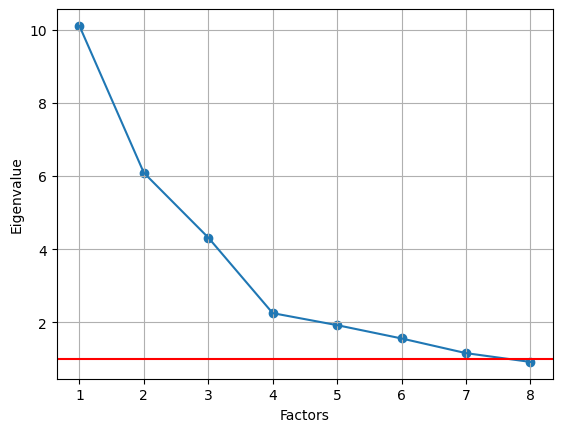

In [2]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# train_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\train_logP_v3.csv', index_col=0)
# test_df = pd.read_csv(r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\csv_for_rulefit\test_logP_v3.csv', index_col=0)

features_to_analyse = []
for feature_name in merged_dataframe.columns:
    if len(merged_dataframe[feature_name].unique()) != 1:
        features_to_analyse.append(feature_name)
features_to_analyse.remove('fold_id')

fa = FactorAnalyzer(rotation=None)

df_features = merged_dataframe[features_to_analyse]
# df_features = StandardScaler().fit_transform(df_features)
fa.fit(df_features)

ev, _ = fa.get_eigenvalues()
for index, en_value in enumerate(ev):
    if en_value < 1:
        break
index += 1

plt.scatter(range(1, index + 1), ev[:index])
plt.plot(range(1, index + 1), ev[:index])
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y = 1, color='r')
plt.grid()
plt.show()

In [3]:
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df_features)
kmo_model

c:\work\DrugDiscovery\drug-discovery-venv\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.6239602297891018

In [4]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

df_for_bartlett_sphericity = StandardScaler().fit_transform(df_features)
chi_square_value, p_value = calculate_bartlett_sphericity(df_for_bartlett_sphericity)
print(f"statistics: {chi_square_value}, p-value: {p_value}")

statistics: 11030.040954824713, p-value: 0.0


In [5]:
from sklearn.preprocessing import StandardScaler

n_factors = 7

fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")

fa.fit(df_features)

fa_load = pd.DataFrame(fa.loadings_,index=df_features.columns)
fa_load.style.background_gradient(cmap="coolwarm")

,0,1,2,3,4,5,6
f_freedom,-0.362566,0.017590,-0.168421,-0.730520,0.125812,-0.195287,0.128615
distance_between_atoms_in_cycle_and_f_group,0.926541,0.008531,0.176059,0.086969,0.036879,0.049971,0.027155
PPSA5,0.185657,-0.061437,0.142254,0.240290,-0.400971,0.695177,-0.021480
mol_num_cycles,0.084508,0.922421,0.284980,0.046856,-0.029951,-0.130597,0.056740
nFRing,-0.154710,0.787342,0.272866,0.046318,0.168922,0.073312,0.193402
angle_R1X1R2,0.972522,0.018951,0.005267,0.081045,0.069899,0.066673,0.068464
nF,0.535480,-0.154120,0.028334,0.628134,0.063616,0.527672,0.078909
identificator,0.102796,0.099629,0.051991,-0.023787,0.888306,-0.123985,-0.057494
mol_weight,0.415466,0.185595,0.539407,0.406379,-0.274683,0.391292,-0.004118
dipole_moment,0.033252,0.070426,0.045317,0.282339,0.198781,-0.014984,0.132577


Factor: 0, feature: distance_between_atoms_in_cycle_and_f_group, representation: 0.9265405667882703, logP repsentation: -0.10213310054412394


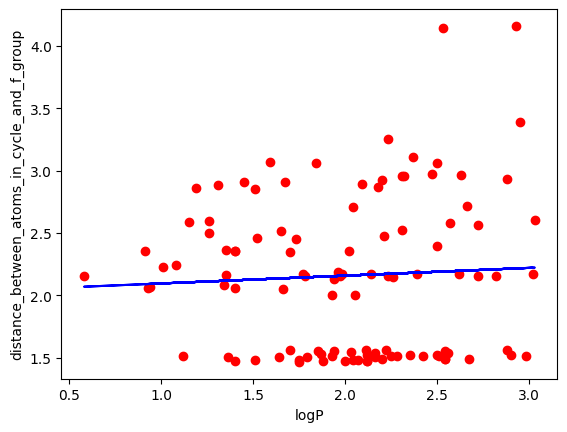

Factor: 0, feature: angle_R1X1R2, representation: 0.9725224847974773, logP repsentation: -0.10213310054412394


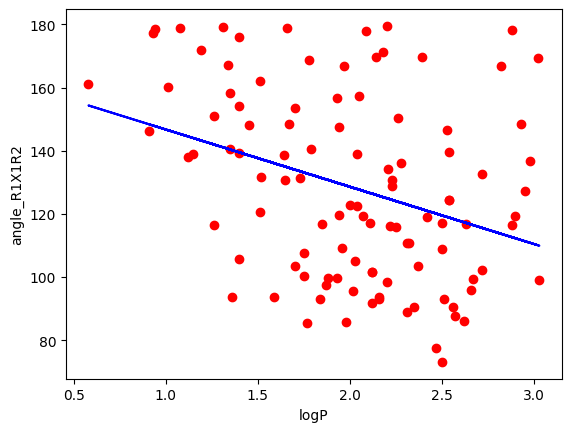

Factor: 0, feature: angle_X2X1R1, representation: 0.9588364948207304, logP repsentation: -0.10213310054412394


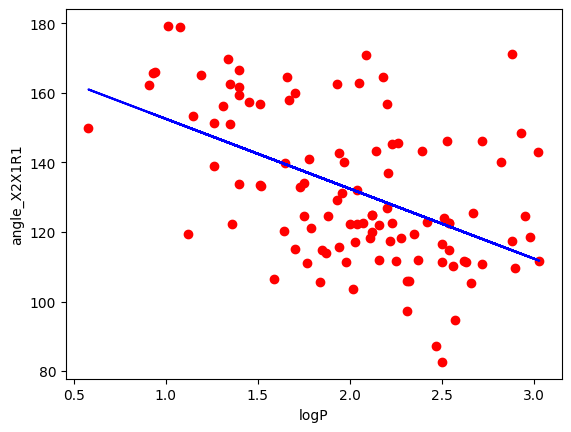

Factor: 0, feature: angle_R2X2R1, representation: 0.9770504282014294, logP repsentation: -0.10213310054412394


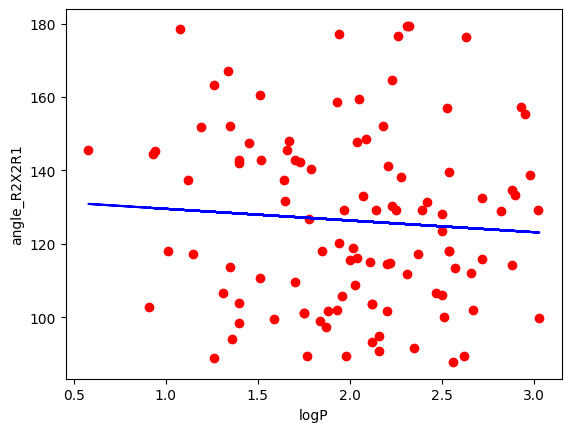

Factor: 0, feature: f_to_fg, representation: 0.7428980059501865, logP repsentation: -0.10213310054412394


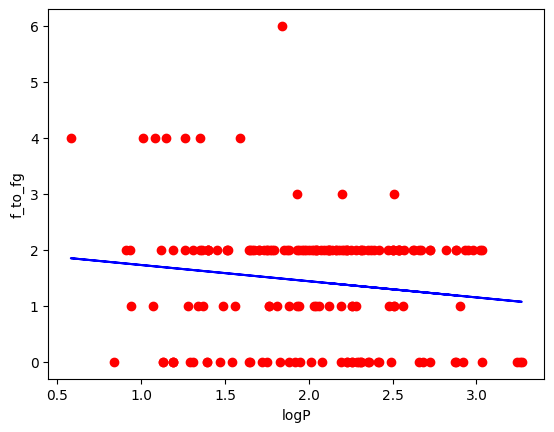

Factor: 0, feature: dihedral_angle, representation: 0.6743787382062976, logP repsentation: -0.10213310054412394


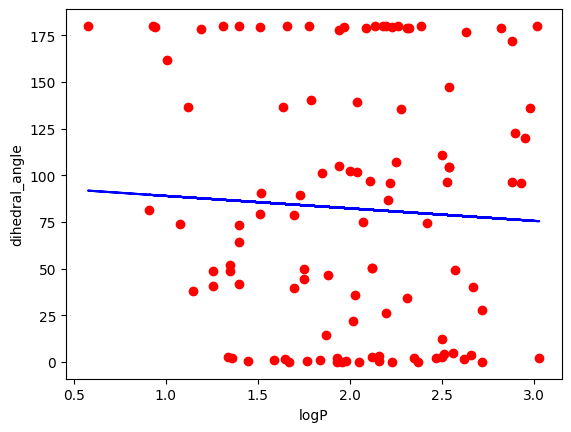

Factor: 0, feature: distance_between_atoms_in_f_group_centers, representation: 0.9777425625163858, logP repsentation: -0.10213310054412394


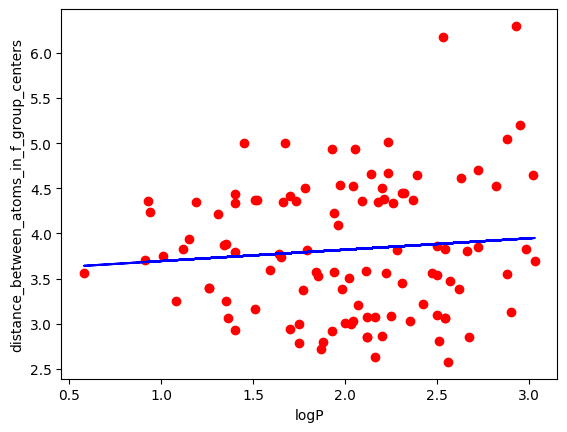

Factor: 0, feature: angle_X1X2R2, representation: 0.95419140368054, logP repsentation: -0.10213310054412394


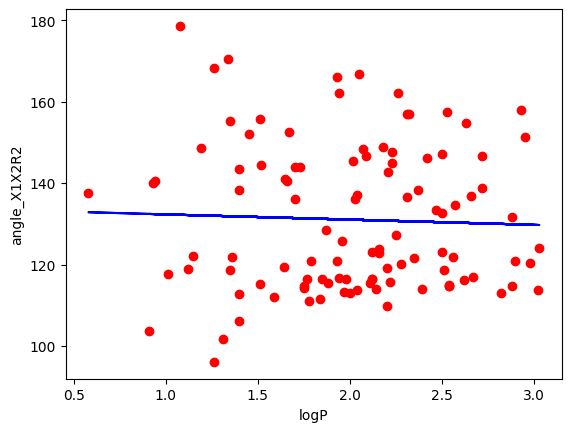

Factor: 1, feature: mol_num_cycles, representation: 0.9224207411456661, logP repsentation: -0.019786267221563927


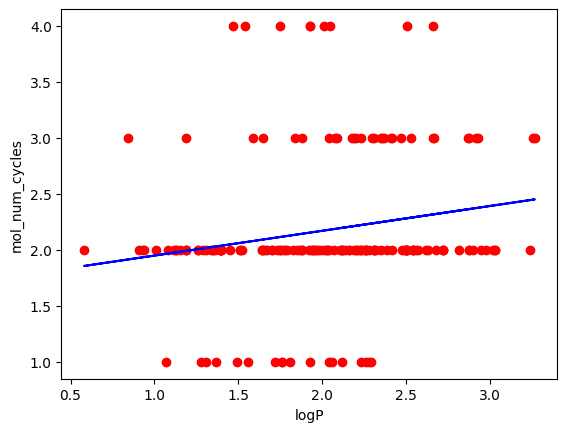

Factor: 1, feature: nFRing, representation: 0.787342478337825, logP repsentation: -0.019786267221563927


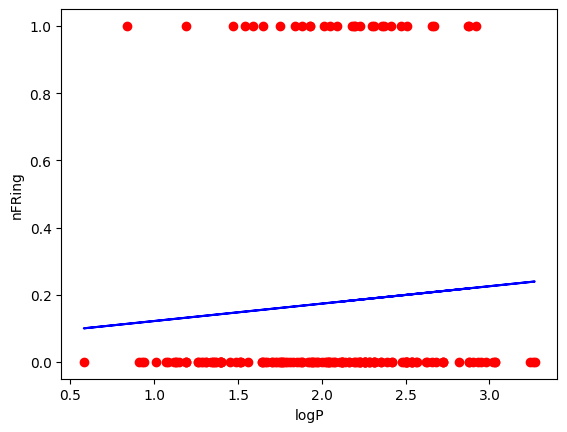

Factor: 1, feature: nARing, representation: 0.9191565954059547, logP repsentation: -0.019786267221563927


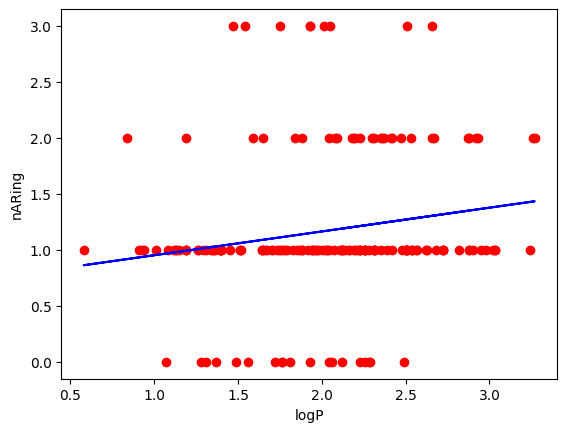

Factor: 1, feature: avg_atoms_in_cycle, representation: -0.8125722955135029, logP repsentation: -0.019786267221563927


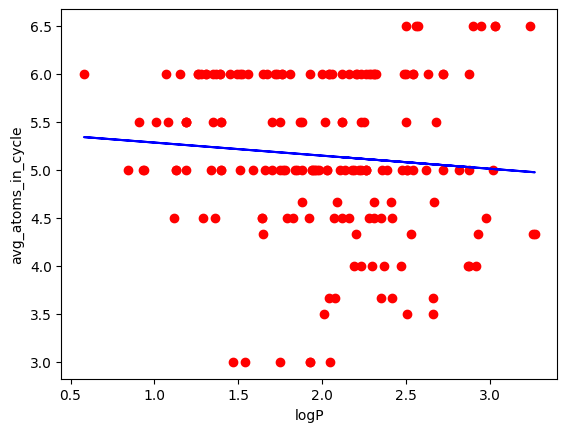

Factor: 1, feature: nFHRing, representation: 0.7532886427671001, logP repsentation: -0.019786267221563927


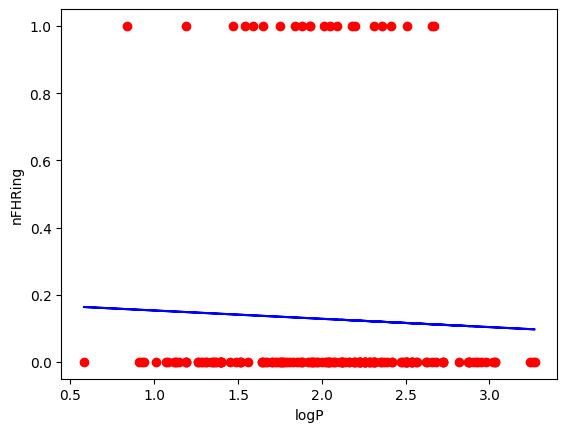

Factor: 2, feature: PBF, representation: 0.6798086304821727, logP repsentation: 0.5680966991604589


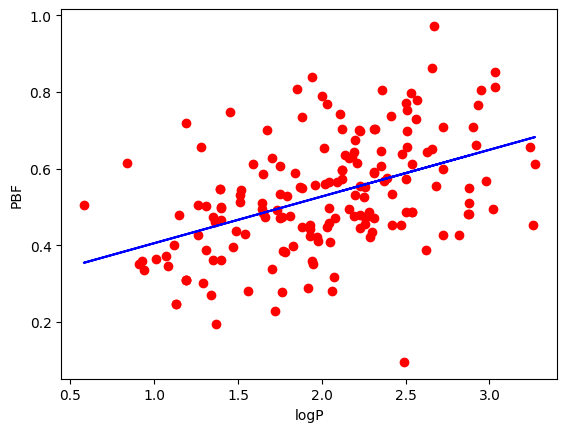

Factor: 2, feature: nC, representation: 0.9168663401224452, logP repsentation: 0.5680966991604589


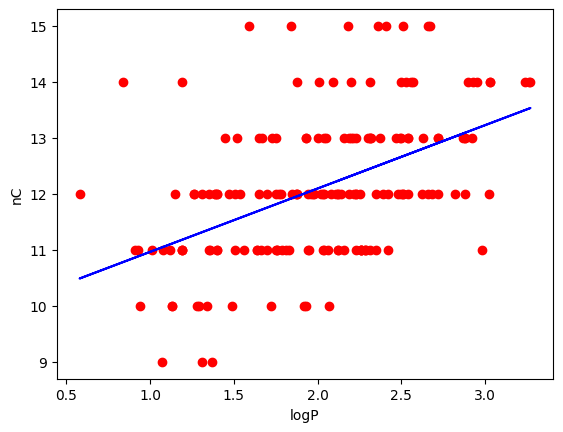

Factor: 2, feature: mol_volume, representation: 0.8921055852291092, logP repsentation: 0.5680966991604589


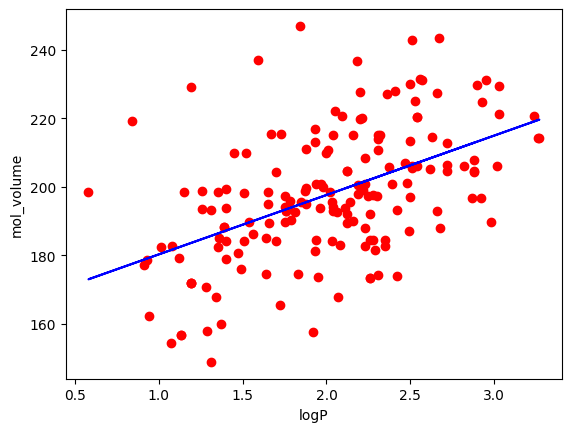

Factor: 3, feature: f_freedom, representation: -0.7305202781586844, logP repsentation: 0.3714659418224717


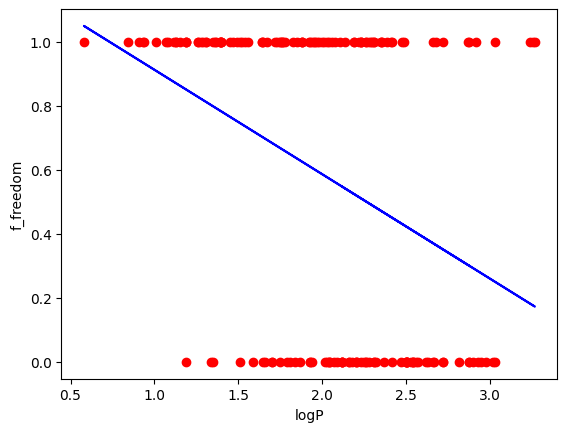

Factor: 3, feature: nF, representation: 0.6281342848487672, logP repsentation: 0.3714659418224717


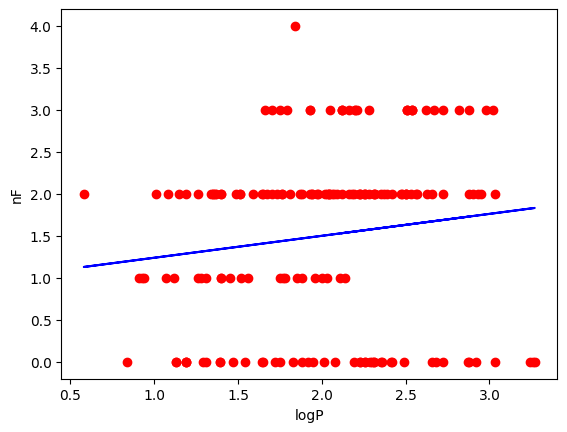

Factor: 3, feature: FPSA3, representation: -0.8002588516966828, logP repsentation: 0.3714659418224717


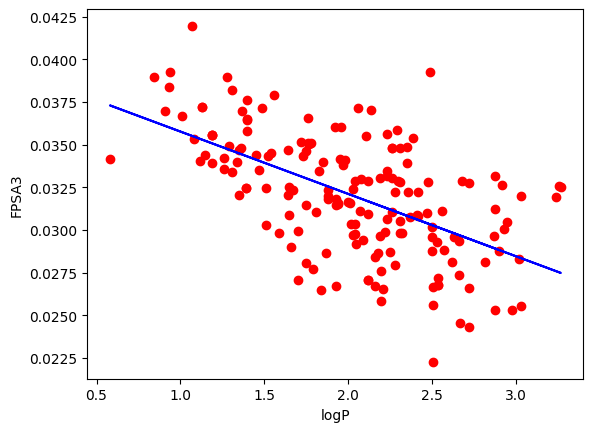

Factor: 3, feature: RPCS, representation: -0.7320577050504197, logP repsentation: 0.3714659418224717


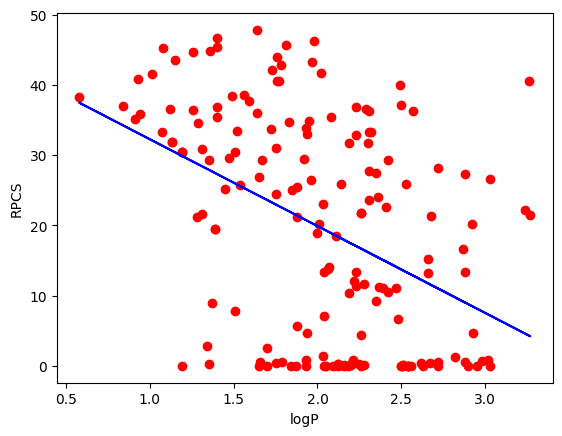

Factor: 4, feature: identificator, representation: 0.8883062832270032, logP repsentation: -0.6618633391376767


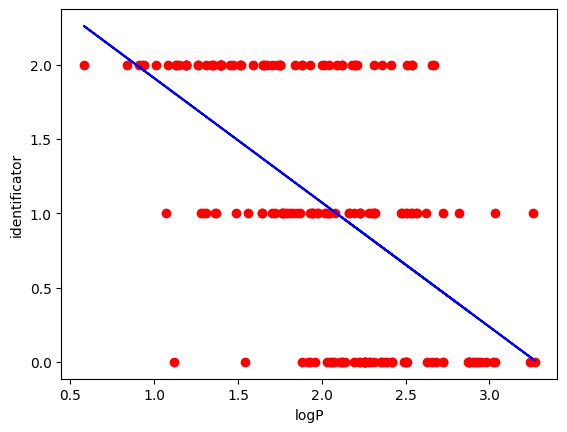

Factor: 4, feature: nHRing, representation: 0.66677452785107, logP repsentation: -0.6618633391376767


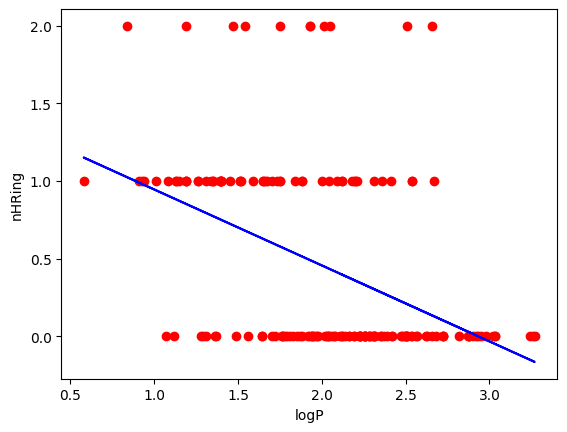

Factor: 5, feature: PPSA5, representation: 0.6951765831125035, logP repsentation: -0.06925073597287641


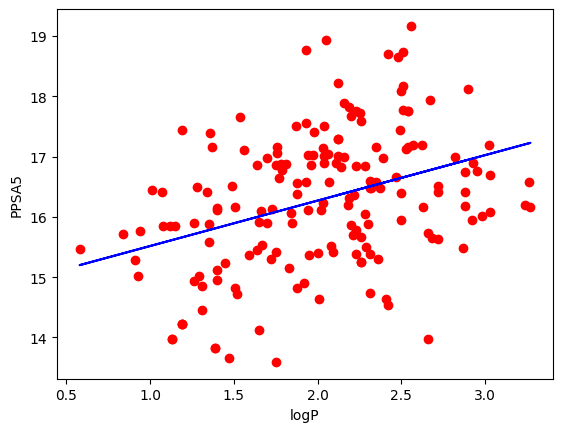

Factor: 5, feature: WPSA5, representation: 0.6553525828596198, logP repsentation: -0.06925073597287641


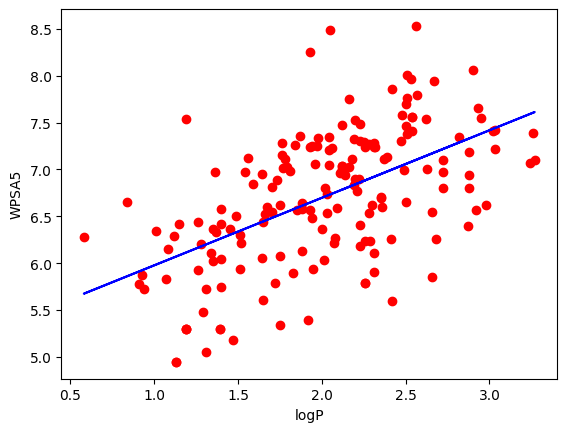

Factor: 6, feature: cis/trans, representation: 0.7359343679667151, logP repsentation: 0.03770065850327203


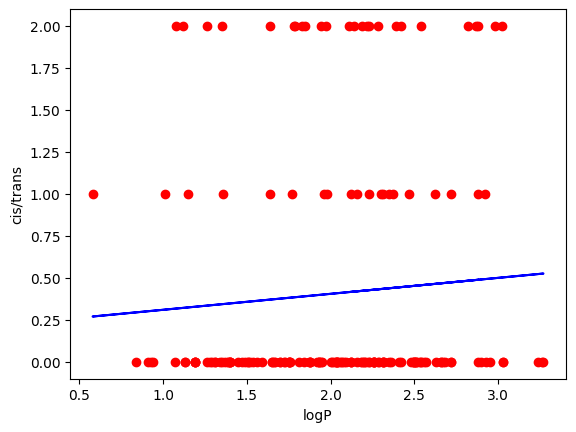

Factor: 6, feature: chirality, representation: 0.6315964933484528, logP repsentation: 0.03770065850327203


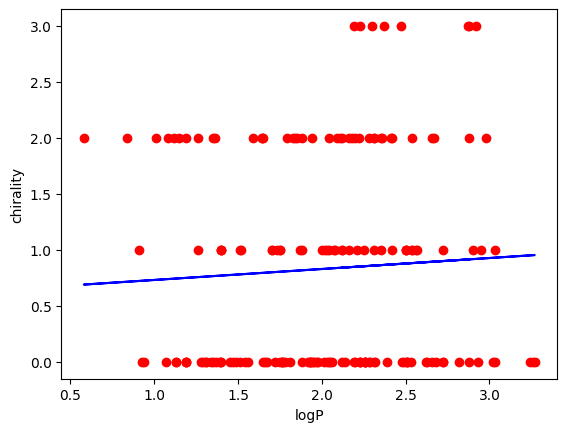

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

feature_names = df_features.columns

for factor_index in range(n_factors):
    factor_representation = fa.loadings_[:, factor_index]

    for feature_index in range(len(feature_names)):
        if abs(factor_representation[feature_index]) < 0.6:
            continue

        if feature_names[feature_index] == 'logP':
            continue

        print(f"Factor: {factor_index}, feature: {feature_names[feature_index]}, representation: {factor_representation[feature_index]}, logP repsentation: {factor_representation[-1]}")

        _x = list(df_features['logP'])
        _y = list(df_features[feature_names[feature_index]])
        x, y = [], []
        for index in range(len(_x)):
            if _y[index] == 0 and ("angle" in feature_names[feature_index] or "distance" in feature_names[feature_index]):
                continue
            else:
                x.append(_x[index])
                y.append(_y[index])

        slope, intercept, r, p, se = linregress(x, y)
        y_line = [slope * xi + intercept for xi in x]

        plt.scatter(x=x, y=y, color="red")
        plt.plot(x, y_line, color="blue")
        plt.xlabel('logP')
        plt.ylabel(feature_names[feature_index])
        plt.show()
